In [5]:
import os
import torch
import clip
import hnswlib
import numpy as np
from PIL import Image, ExifTags
from pillow_heif import register_heif_opener
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress tracking


# Load CLIP model and set device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/16", device=device)

SIMILARITY_CUTOFF = 0.25  # Reasonable threshold to filter low similarity results
IMAGES_PER_ROW = 5

In [6]:
def get_image_embeddings(image_paths):
    """
    Extracts CLIP embeddings for a list of images.
    """
    all_embeddings = []
    batch_size = 32  # Adjust based on memory availability
    register_heif_opener()
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Embedding Images"):
        batch_paths = image_paths[i:i+batch_size]
        images = [preprocess(Image.open(img_path)).unsqueeze(0) for img_path in batch_paths]
        image_inputs = torch.cat(images).to(device)
        
        with torch.no_grad():
            features = model.encode_image(image_inputs)
            features = features / features.norm(dim=-1, keepdim=True)  # Normalize
            
        all_embeddings.append(features.cpu().numpy())
    
    return np.vstack(all_embeddings)  # Stack all batches into a single array

def get_text_embedding(text_query):
    """
    Extracts CLIP embedding for a text query.
    """
    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize([text_query]).to(device))
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)  # Normalize
    return text_features.cpu().numpy()[0]  # Convert to NumPy 1D array


In [7]:
def cosine_search(image_embeddings, text_embedding, top_k=1):
    """
    Finds the top-k most similar images using cosine similarity.
    """
    similarities = np.dot(image_embeddings, text_embedding)  # Faster than sklearn cosine_similarity
    top_matches = np.argsort(similarities)[-top_k:][::-1]  # Get top-k matches
    return top_matches, similarities[top_matches]


def hnsw_search(image_embeddings, text_embedding, top_k=1):
    """
    Finds the top-k most similar images using HNSW graph search.
    """
    dim = image_embeddings.shape[1]
    num_elements = image_embeddings.shape[0]
    
    hnsw_index = hnswlib.Index(space='cosine', dim=dim)
    hnsw_index.init_index(max_elements=num_elements, ef_construction=200, M=32)
    hnsw_index.add_items(image_embeddings, np.arange(num_elements))
    hnsw_index.set_ef(100)  # Increase search quality
    
    labels, _ = hnsw_index.knn_query(text_embedding, k=top_k)
    return labels[0]

def correct_image_orientation(img):
    """
    Corrects the image orientation using EXIF data if available.
    """
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = img._getexif()
        if exif is not None and orientation in exif:
            if exif[orientation] == 3:
                img = img.rotate(180, expand=True)
            elif exif[orientation] == 6:
                img = img.rotate(270, expand=True)
            elif exif[orientation] == 8:
                img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        pass  # Image has no EXIF data or orientation tag
    return img


def show_images(image_paths, indices, similarities, title="Top Matching Images"):
    """
    Displays images in a gallery layout with a max of IMAGES_PER_ROW per row.
    """
    num_images = len(indices)
    num_rows = (num_images + IMAGES_PER_ROW - 1) // IMAGES_PER_ROW  # Calculate needed rows
    fig, axes = plt.subplots(num_rows, IMAGES_PER_ROW, figsize=(5 * IMAGES_PER_ROW, 5 * num_rows))
    axes = np.array(axes).reshape(-1)  # Flatten axes array for easy iteration
    
    for ax, idx, sim in zip(axes[:num_images], indices, similarities):
        img = Image.open(image_paths[idx])
        img = correct_image_orientation(img)  # Correct orientation
        ax.imshow(img)
        ax.set_title(f"Sim: {sim:.4f}")  # Display similarity score
        ax.axis("off")
    
    # Hide unused subplots
    for ax in axes[num_images:]:
        ax.axis("off")
    
    plt.suptitle(title)
    plt.show()

In [ ]:
# Example usage
print(f"Device in use: {device}")
# image_dir = "/Users/adityapatil/Pictures/Kuari Pass"
image_dir = "/Users/adityapatil/photos_backup"

image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.lower().endswith((".jpg", ".png", ".jpeg", ".heic"))][3500:4000]
print(f"total Images beinf embedded: {len(image_paths)}")
# Generate embeddings
# image_embeddings = get_image_embeddings(image_paths)

Device in use: mps
500


Embedding Images:   0%|          | 0/16 [00:00<?, ?it/s]

Embedding Images: 100%|██████████| 16/16 [01:10<00:00,  4.41s/it]


In [63]:

query = "convocation"
# query = "a photo of evening orange glow over a snow capped mountain peak"
text_embedding = get_text_embedding(query)


Filtered Matches Above Similarity Cutoff:
/Users/adityapatil/photos_backup/IMG_7747.HEIC - Similarity: 0.2673
/Users/adityapatil/photos_backup/UJAGE5008.JPG - Similarity: 0.2671
/Users/adityapatil/photos_backup/RAGFE8088.JPG - Similarity: 0.2659
/Users/adityapatil/photos_backup/IMG_7751.HEIC - Similarity: 0.2642
/Users/adityapatil/photos_backup/CQSLE6992.JPG - Similarity: 0.2517


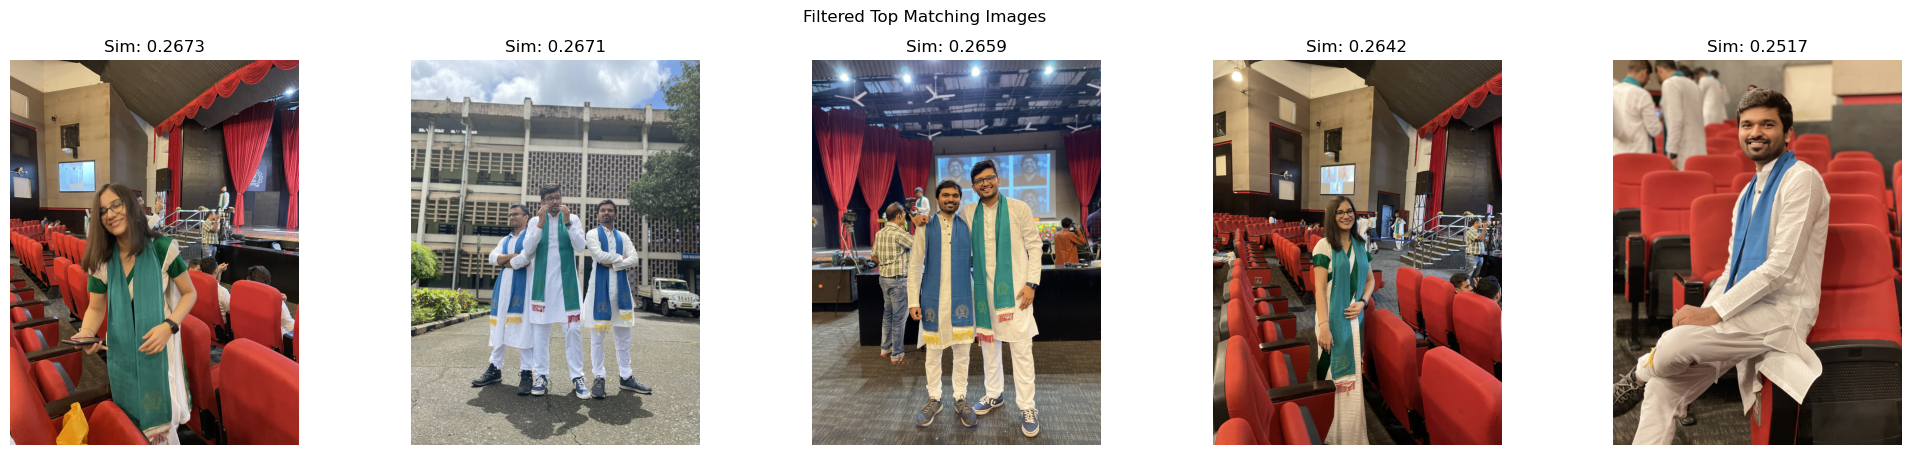

In [64]:
top_k = 10


# Measure Cosine Search Time
# start_time = time.time()
cosine_matches, cosine_similarities = cosine_search(image_embeddings, text_embedding, top_k=top_k)
# cosine_time = time.time() - start_time

# Measure HNSW Search Time
# start_time = time.time()
# hnsw_matches = hnsw_search(image_embeddings, text_embedding, top_k=top_k)
# hnsw_time = time.time() - start_time

# Apply similarity cutoff
top_m_indices = [idx for idx, sim in zip(cosine_matches, cosine_similarities) if sim >= SIMILARITY_CUTOFF]
top_m_similarities = [sim for sim in cosine_similarities if sim >= SIMILARITY_CUTOFF]

if len(top_m_indices) == 0:
    print("No image with the description found.")
    print("Would you be interested in seeing other remotely similar images?")
    top_m_indices = cosine_matches[:2]  # Show the top 2 best matches regardless of score
    top_m_similarities = cosine_similarities[:2]

# Print results
print(f"Filtered Matches Above Similarity Cutoff:")
for idx, sim in zip(top_m_indices, top_m_similarities):
    print(f"{image_paths[idx]} - Similarity: {sim:.4f}")


# Show filtered images as a collage with similarity scores
show_images(image_paths, top_m_indices, top_m_similarities, title="Filtered Top Matching Images")



# Print results
# print(f"Top {top_k} Cosine Similarity Matches: {[image_paths[i] for i in cosine_matches]} (Time: {cosine_time:.6f} sec)")
# print(f"Top {top_k} HNSW Matches: {[image_paths[i] for i in hnsw_matches]} (Time: {hnsw_time:.6f} sec)")

# Print embeddings
# print("Best Image Embedding:", image_embeddings[cosine_matches[0]][:10])
# print("Text Embedding:", text_embedding[:20])

# Show top-k images as a collage
# show_images(image_paths, cosine_matches, cosine_similarities, title="Top Cosine Similarity Matches")

In [75]:
query = "Photos of tortoise in a pond"
# query = "a photo of evening orange glow over a snow capped mountain peak"
text_embedding = get_text_embedding(query)

# Testing chromadb

In [34]:
import chromadb

In [35]:
client = chromadb.PersistentClient(path="")
image_loader = ImageLoader()
multimodal_ef = OpenCLIPEmbeddingFunction()
collection = client.get_or_create_collection(
    name=index_name,
    embedding_function=multimodal_ef,
    data_loader=image_loader,
    metadata={"hnsw:space": "cosine"}
)


NameError: name 'vectordb' is not defined

In [88]:
# query = "a photo of evening orange glow over a snow capped mountain peak"
text_embedding1 = get_text_embedding(query1)
text_embedding2 = get_text_embedding(query2)
text_embedding3 = get_text_embedding(query3)

text_embedding4 = text_embedding1 + text_embedding2

In [89]:
print(text_embedding1[:15])
print(text_embedding2[:15])
print(text_embedding3[:15])
print(text_embedding4[:15])

[-0.005768 -0.013245  0.01785   0.01625   0.02278  -0.03116  -0.01816
 -0.03207  -0.01206   0.0143    0.02168   0.02087  -0.0043    0.02422
 -0.02393 ]
[-0.003244 -0.0534   -0.00618   0.005802  0.0118    0.002829 -0.00692
 -0.05072  -0.013985  0.0457   -0.01746   0.01411   0.01422   0.01283
 -0.0289  ]
[-0.006332  -0.01425    0.02293    0.02454   -0.001145  -0.01701
  0.0002732 -0.02875    0.001602   0.01385    0.01689    0.03044
 -0.01356    0.0236    -0.03235  ]
[-0.00901  -0.06665   0.01167   0.02205   0.03458  -0.02834  -0.02509
 -0.08276  -0.02605   0.06      0.004227  0.03497   0.00992   0.03705
 -0.05283 ]


In [90]:
# similarity11 = np.dot(text_embedding1, text_embedding1)
similarity12 = np.dot(text_embedding1, text_embedding2)/np.linalg.norm(text_embedding1)/np.linalg.norm(text_embedding2)
similarity34 = np.dot(text_embedding3, text_embedding4)/np.linalg.norm(text_embedding3)/np.linalg.norm(text_embedding4)
similarity13 = np.dot(text_embedding1, text_embedding3)/np.linalg.norm(text_embedding1)/np.linalg.norm(text_embedding3)
similarity23 = np.dot(text_embedding2, text_embedding3)/np.linalg.norm(text_embedding2)/np.linalg.norm(text_embedding3)
# similarity1 = np.dot(image_embeddings, text_embedding)

print(similarity12)
print(similarity13)
print(similarity23)
print(similarity34)

0.8945
0.977
0.88
0.9536
